# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ztest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression, SelectFromModel
from scipy.stats import zscore
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from pandas.plotting import scatter_matrix
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import plotly.io as pio
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance


# Reading & Merging & Preprocessing 

In [2]:
class DataLoadMergePreprocess:
    def __init__(self, features_path='features.csv', stores_path='stores.csv', train_path='train.csv'):
        self.features_path = features_path
        self.stores_path = stores_path
        self.train_path = train_path
        self.df = pd.DataFrame()

    def load_merge_data(self):
        """
        Load and merge data from features, stores, and train CSV files into one dataframe.
        """
        # Load data from CSV files
        self.features = pd.read_csv(self.features_path)
        self.stores = pd.read_csv(self.stores_path)
        self.train = pd.read_csv(self.train_path)

        # Fill missing values in the 'MarkDown' columns with zeros
        MarkDown_column = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
        for column in MarkDown_column:
            median_value = self.features[column].median()
            self.features[column] = self.features[column].fillna(median_value)
        
        # Fill missing values in 'CPI' and 'Unemployment' columns with the last recorded non-null value
        other = ['CPI', 'Unemployment']
        for column in other:
            self.features[column] = self.features[column].fillna(method='ffill')

        # Merge the train, stores, and features dataframes based on common columns
        train_stores = pd.merge(self.train, self.stores, on='Store')
        self.df = pd.merge(train_stores, self.features, on=['Store', 'Date', 'IsHoliday'])

    def preprocess(self, holiday_columns=True):

        """
        Applying data transformation to the data along with applying the holiday function that adds new columns representing each holiday.
        """
        if self.df is None:
            raise Exception("Data has not been loaded and merged yet.")
        # Stripping whitespace from column names
        self.df.columns = self.df.columns.str.strip()

        # Transforming the date column into datetime and extracting all the needed features from the date column 
        self.df['Date'] = pd.to_datetime(self.df['Date']) 
        self.df['Week'] = self.df['Date'].dt.isocalendar().week.astype(int)
        self.df['Month'] = self.df['Date'].dt.month
        self.df['Year'] = self.df['Date'].dt.year
        # self.df.drop(columns=['Date'], axis=1, inplace=True)

        # Transforming the Temperature column from K to C 
        self.df['Temperature'] = (self.df['Temperature'] - 32) * 5/9
        
        # Taking the absolute value of the target column 
        self.df['Weekly_Sales'] = self.df['Weekly_Sales'].abs()

        if holiday_columns:
            # Extracting holiday names from IsHoliday column 
            self.df = self.add_holiday_columns(self.df)

    def encoding(self, df, bool_col=['IsHoliday', 'Super_Bowl', 'Labour_Day', 'Thanksgiving_Day', 'Christmas'], 
                    cat_col='Type', bool_enc_type='numeric', cat_enc_type='numeric'):

        """
        Giving the user multiple ways to encode the boolean column along with the categorical columns.
        """
        if self.df is None:
            raise Exception("Data has not been loaded and merged yet.")

        if bool_enc_type == 'numeric':
            df[bool_col] = np.where(df[bool_col] == True, 1, 0)
        elif bool_enc_type == 'onehotencode':
            df = pd.get_dummies(df, columns=[bool_col])
        elif bool_enc_type == 'labelencode':
            le = LabelEncoder()
            df[bool_col] = le.fit_transform(df[bool_col])
        else:
            raise ValueError("Invalid boolean encoding type. Please choose 'numeric', 'onehotencode', or 'labelencode'.")

        if cat_enc_type == 'numeric':
            df[cat_col] = np.where(df[cat_col] == 'A', 3, np.where(df[cat_col] == 'B', 2, 1))
        elif cat_enc_type == 'onehotencode':
            df = pd.get_dummies(df, columns=[cat_col])
        elif cat_enc_type == 'ordinalencode':
            oe = OrdinalEncoder()
            df[cat_col] = oe.fit_transform(df[cat_col])
        else:
            raise ValueError("Invalid categorical encoding type. Please choose 'numeric', 'onehotencode' or 'ordinalencode'.")

        return df

    def outlier_treatment(self, df):

        """
        Detecting the outliers in numerical columns and teating them by repalcing the values, 
        when the value is higher than the upper whisker it will be replaced by the upper whisker, 
        and when its lower than the lower whisker it would be replaced with the lower whisker.
        """
        whisker_multiplier = 1.5
        col_num = ['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',]
        for column in col_num:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_whisker = Q1 - whisker_multiplier * IQR
            upper_whisker = Q3 + whisker_multiplier * IQR

            df[column] = np.where(df[column] < lower_whisker, lower_whisker, df[column])
            df[column] = np.where(df[column] > upper_whisker, upper_whisker, df[column])

        return df

    def add_holiday_columns(self, df):

        """
        Adding Columns per each holiday to the data
        """
        if self.df is None:
            raise Exception("Data has not been loaded and merged yet.")
        
        # Extracting a column for each holiday that exist in IsHoliday column 
        Super_Bowl = pd.to_datetime(["2010-02-12", "2011-02-11", "2012-02-10", "2013-02-08"])
        Labour_Day = pd.to_datetime(["2010-09-10", "2011-09-09", "2012-09-07", ])
        Thanksgiving_Day = pd.to_datetime(["2010-11-26", "2011-11-25", '2012-11-23'])
        Christmas = pd.to_datetime(["2010-12-31", "2011-12-30", '2012-12-28'])
        df["Super_Bowl"] = df["Date"].isin(Super_Bowl)
        df["Labour_Day"] = df["Date"].isin(Labour_Day)
        df["Thanksgiving_Day"] = df["Date"].isin(Thanksgiving_Day)
        df["Christmas"] = df["Date"].isin(Christmas)
        return df
    
    def split_scale(self, df, scale=True, scaling_method='standard', year_train_start=2010, year_train_end=2012, year_test=2012):

        """
        Returning the data in splitted and scaled form along with the scaler to scale the new test set 
        """
        
        df.sort_values(by='Date', ascending=True, inplace=True)
        df.set_index('Date', inplace=True)

        X_train = df[(df['Year']>=year_train_start) & (df['Year']<year_train_end)].drop('Weekly_Sales', axis=1)
        y_train = df[(df['Year']>=year_train_start) & (df['Year']<year_train_end)]['Weekly_Sales']

        X_test = df[df['Year']==year_test].drop('Weekly_Sales', axis=1)
        y_test = df[df['Year']==year_test]['Weekly_Sales']

        if scale:
            num_col=['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
                                'MarkDown3', 'MarkDown4', 'MarkDown5','CPI','Unemployment']
            
            if scaling_method == 'minmax':
                scaler = MinMaxScaler()
            elif scaling_method == 'standard':
                scaler = StandardScaler()
            else:
                raise ValueError("Invalid scaling method. Please choose 'minmax' or 'standard'.")
            
            X_train[num_col] = scaler.fit_transform(X_train[num_col])
            X_test[num_col] = scaler.transform(X_test[num_col])
        
        return df.drop('Weekly_Sales', axis=1), df['Weekly_Sales'], X_train, X_test, y_train, y_test, scaler
        
    def new_test_data(self, scaler):

        """
        Doing all the preprocessing and transformation steps on the test data that do not have target column
        """
        features = pd.read_csv('features.csv')
        stores = pd.read_csv('stores.csv')
        test = pd.read_csv('test.csv')
        
        # Fill missing values in the 'MarkDown' columns with zeros
        MarkDown_column = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
        for column in MarkDown_column:
            median_value = features[column].median()
            features[column] = features[column].fillna(median_value)
        
        # Fill missing values in 'CPI' and 'Unemployment' columns with the last recorded non-null value
        other = ['CPI', 'Unemployment']
        for column in other:
            features[column] = features[column].fillna(method='ffill')

        # Merge the train, stores, and features dataframes based on common columns
        test_stores = pd.merge(test, stores, on='Store')
        df = pd.merge(test_stores, features, on=['Store', 'Date', 'IsHoliday'])
        df.columns = df.columns.str.strip()

        # Transforming the date column into datetime and extracting all the needed features from the date column 
        df['Date'] = pd.to_datetime(df['Date']) 
        df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        # self.df.drop(columns=['Date'], axis=1, inplace=True)

        # Transforming the Temperature column from K to C 
        df['Temperature'] = (df['Temperature'] - 32) * 5/9
        Super_Bowl = pd.to_datetime(["2010-02-12", "2011-02-11", "2012-02-10", "2013-02-08"])
        Labour_Day = pd.to_datetime(["2010-09-10", "2011-09-09", "2012-09-07", ])
        Thanksgiving_Day = pd.to_datetime(["2010-11-26", "2011-11-25", '2012-11-23'])
        Christmas = pd.to_datetime(["2010-12-31", "2011-12-30", '2012-12-28'])
        df["Super_Bowl"] = df["Date"].isin(Super_Bowl)
        df["Labour_Day"] = df["Date"].isin(Labour_Day)
        df["Thanksgiving_Day"] = df["Date"].isin(Thanksgiving_Day)
        df["Christmas"] = df["Date"].isin(Christmas)

        whisker_multiplier = 1.5
        col_num = ['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
        for column in col_num:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_whisker = Q1 - whisker_multiplier * IQR
            upper_whisker = Q3 + whisker_multiplier * IQR

            df[column] = np.where(df[column] < lower_whisker, lower_whisker, df[column])
            df[column] = np.where(df[column] > upper_whisker, upper_whisker, df[column])

        df.sort_values(by='Date', ascending=True, inplace=True)
        df.set_index('Date', inplace=True)

        num_col=['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
                                'MarkDown3', 'MarkDown4', 'MarkDown5','CPI','Unemployment']
        
        df[num_col] = scaler.transform(df[num_col])

        bool_col=['IsHoliday', 'Super_Bowl', 'Labour_Day', 'Thanksgiving_Day', 'Christmas']
        df[bool_col] = np.where(df[bool_col] == True, 1, 0)
        
        cat_col='Type'
        
        df[cat_col] = np.where(df[cat_col] == 'A', 3, np.where(df[cat_col] == 'B', 2, 1))
        
        return df


In [3]:
# Creating an object to load and process the data 
data_processor = DataLoadMergePreprocess()
data_processor.load_merge_data()
data_processor.preprocess()
df = data_processor.df


In [4]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown5,CPI,Unemployment,Week,Month,Year,Super_Bowl,Labour_Day,Thanksgiving_Day,Christmas
0,1,1,2010-02-05,24924.50,False,A,151315,5.727778,2.572,4743.58,...,2727.135,211.096358,8.106,5,2,2010,False,False,False,False
1,1,2,2010-02-05,50605.27,False,A,151315,5.727778,2.572,4743.58,...,2727.135,211.096358,8.106,5,2,2010,False,False,False,False
2,1,3,2010-02-05,13740.12,False,A,151315,5.727778,2.572,4743.58,...,2727.135,211.096358,8.106,5,2,2010,False,False,False,False
3,1,4,2010-02-05,39954.04,False,A,151315,5.727778,2.572,4743.58,...,2727.135,211.096358,8.106,5,2,2010,False,False,False,False
4,1,5,2010-02-05,32229.38,False,A,151315,5.727778,2.572,4743.58,...,2727.135,211.096358,8.106,5,2,2010,False,False,False,False


In [5]:
df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown5,CPI,Unemployment,Week,Month,Year,Super_Bowl,Labour_Day,Thanksgiving_Day,Christmas
421565,45,93,2012-10-26,2487.80,False,B,118221,14.916667,3.882,4018.91,...,858.33,192.308899,8.667,43,10,2012,False,False,False,False
421566,45,94,2012-10-26,5203.31,False,B,118221,14.916667,3.882,4018.91,...,858.33,192.308899,8.667,43,10,2012,False,False,False,False
421567,45,95,2012-10-26,56017.47,False,B,118221,14.916667,3.882,4018.91,...,858.33,192.308899,8.667,43,10,2012,False,False,False,False
421568,45,97,2012-10-26,6817.48,False,B,118221,14.916667,3.882,4018.91,...,858.33,192.308899,8.667,43,10,2012,False,False,False,False
421569,45,98,2012-10-26,1076.80,False,B,118221,14.916667,3.882,4018.91,...,858.33,192.308899,8.667,43,10,2012,False,False,False,False


### Data Explorering

Converting the date column to datetime and extracting all the relavent information

In [ ]:
sales_drop = df.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()

The mean of weekly sales is generally consistent across the months, except for January and the months following November and December, where the sales show a significant drop.

In [ ]:
sales_drop.head()

In [ ]:
sales_precent_drop = (1 - sales_drop[sales_drop['Month']==1]['Weekly_Sales'].mean() / sales_drop[sales_drop['Month']==12]['Weekly_Sales'].mean())* 100
print(f'The precentage of sales drop in December 2010 and January 2011 is: {round(sales_precent_drop, 1)} %')

In [ ]:
def save_plot_as_image(fig, file_name, file_path, width=None, height=None):
    """
    Save a Plotly figure as an image at the specified file path.

    Args:
        fig (plotly.graph_objs.Figure): The Plotly figure to save.
        file_name (str): The name of the image file.
        file_path (str): The path where the image file should be saved.
    """
    # Create the folder if it doesn't exist
    os.makedirs(file_path, exist_ok=True)

    # Save the figure as an image
    file_name_with_extension = f"{file_name}.png"
    file_path_with_extension = os.path.join(file_path, file_name_with_extension)
    pio.write_image(fig, file_path_with_extension, format="png", scale=5, width=width, height=height)


# Data Analysis 

In [ ]:
Store_vs_WeeklySale = df.groupby(['Store']).agg({'Weekly_Sales': 'mean'}).reset_index()

Store_vs_WeeklySale['Group'] = pd.cut(Store_vs_WeeklySale['Weekly_Sales'], 
                                      bins=[0, 5000, 10000, 15000, 20000, 25000, 30000],
                                      labels=['0 - 5000', '5000 - 10000', '10000 - 15000',
                                              '15000 - 20000', '20000 - 25000', '25000 - 30000'])

Store_vs_WeeklySale = Store_vs_WeeklySale.groupby(['Group'])['Weekly_Sales'].agg('count').reset_index()

# Average_Weekly_Sales_By_Store_fig = px.bar(Store_vs_WeeklySale, x='Store', y='Weekly_Sales',
#                                            title='Average Weekly Sale by Store')

# Average_Weekly_Sales_By_Store_fig.update_layout(
#     xaxis_title="Store", yaxis_title="Average Weekly Sale")

# Average_Weekly_Sales_By_Store_fig.show()
# save_plot_as_image(Average_Weekly_Sales_By_Store_fig,
#                    'Average_Weekly_Sales_By_Store_fig.png', 'figures/', width=1200, height=600)



In [ ]:
fig = px.bar(Store_vs_WeeklySale, x = 'Group', y='Weekly_Sales', title= 'Average Weekly Sales by Stores Groups', width=800, height=600)
fig.update_layout(
    xaxis_title="Groups of Store based on Average Weekly Sale", yaxis_title="Count of Stores")
fig.show()

In [ ]:
store_sale = df.groupby(['Month', 'Store'])['Weekly_Sales'].agg(
    ['mean', 'count', 'sum']).reset_index()
heatmap_data = store_sale.pivot("Store", "Month", "mean")

Average_Weekly_Sales_By_Store_month_fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale="YlGnBu",
    hovertemplate='Store: %{y}<br>Month: %{x}<br>Average Weekly Sales: %{z}<extra></extra>',
    # Round the values in the cells
    text=np.round(heatmap_data.values, decimals=1),
    zmid=sum(heatmap_data.min()) / 2  
))

Average_Weekly_Sales_By_Store_month_fig.update_layout(
    title="Average Sales for Store by Month",
    xaxis_title="Month",
    yaxis_title="Store"
)

Average_Weekly_Sales_By_Store_month_fig.update_layout(
    autosize=False,
    width=900,
    height=900
)

Average_Weekly_Sales_By_Store_month_fig.update_layout(
    annotations=[
        go.layout.Annotation(
            x=month,
            y=store,
            text=str(value),
            showarrow=False,
            font=dict(color='black')
        )
        for month in heatmap_data.columns
        for store in heatmap_data.index
        for value in [np.round(heatmap_data.loc[store, month], decimals=1)]
    ]
)

Average_Weekly_Sales_By_Store_month_fig.show()

# save_plot_as_image(Average_Weekly_Sales_By_Store_month_fig,
#                    'Average_Weekly_Sales_By_Store_month_fig.png', 'figures/', width=900, height=900)


### Department vs Average Weekly Sales

In [ ]:

store_sale = df.groupby(['Month', 'Dept'])['Weekly_Sales'].agg(
    ['mean', 'count', 'sum']).reset_index()
heatmap_data = store_sale.pivot("Dept", "Month", "mean")

heatmap_data_filled = heatmap_data.fillna(0)

rounded_heatmap_data = heatmap_data_filled.round(1)

Average_Weekly_Sales_By_Dept_month_fig = go.Figure(data=go.Heatmap(
    z=heatmap_data_filled.values,
    x=heatmap_data_filled.columns,
    y=heatmap_data_filled.index,
    colorscale="YlGnBu",
    hovertemplate='Dept: %{y}<br>Month: %{x}<br>Average Weekly Sales: %{z}<extra></extra>',
    text=np.round(rounded_heatmap_data.values, decimals=1),
    zmid=np.mean(rounded_heatmap_data.min())  
))

Average_Weekly_Sales_By_Dept_month_fig.update_layout(
    title="Average Sales for Department by Month",
    xaxis_title="Month",
    yaxis_title="Dept"
)

Average_Weekly_Sales_By_Dept_month_fig.update_xaxes(tickangle=45)

Average_Weekly_Sales_By_Dept_month_fig.update_layout(
    autosize=False,
    width=1200,
    height=1200
)

Average_Weekly_Sales_By_Dept_month_fig.update_layout(
    annotations=[
        go.layout.Annotation(
            x=month,
            y=dept,
            text=str(value),
            showarrow=False,
            font=dict(color='black')
        )
        for month in rounded_heatmap_data.columns
        for dept in rounded_heatmap_data.index
        for value in [rounded_heatmap_data.loc[dept, month]]
    ]
)

Average_Weekly_Sales_By_Dept_month_fig.show()

# save_plot_as_image(Average_Weekly_Sales_By_Dept_month_fig,
#                    'Average_Weekly_Sales_By_Dept_month_fig.png', 'figures/', width=1400, height=1500)


In [ ]:
Store_size_vs_WeeklySale = df.groupby(['Store', 'Size'])[
    'Weekly_Sales'].mean().reset_index()

Average_Weekly_Sales_Store_Size = px.bar(Store_size_vs_WeeklySale,
                                         x='Store', y='Weekly_Sales', color='Size', title="Average Weekly Sales by Store and Size of Store ")
Average_Weekly_Sales_Store_Size.show()

# save_plot_as_image(Average_Weekly_Sales_Store_Size,
#                    'Average_Weekly_Sales_Store_Size.png', 'figures/', width=1200, height=600)

## Fuel Price, Temperature, CPI, Unemployment Vs Weekly Sales

In [ ]:
Fuel_Price_vs_WeeklySale = df.groupby(['Fuel_Price'])[
    'Weekly_Sales'].mean().reset_index()

Average_Weekly_Sales_Fuel_Price = px.line(Fuel_Price_vs_WeeklySale,
                                             x='Fuel_Price', y='Weekly_Sales', title="Average Weekly Sales by Fuel Price")
Average_Weekly_Sales_Fuel_Price.show()

# save_plot_as_image(Average_Weekly_Sales_Fuel_Price,
#                    'Average_Weekly_Sales_Fuel_Price.png', 'figures/', width=1200, height=600)


In [ ]:

temp_vs_WeeklySale = df.groupby(['Temperature'])[
    'Weekly_Sales'].mean().reset_index()

Average_Weekly_Sales_Temp = px.line(temp_vs_WeeklySale,
                                       x='Temperature', y='Weekly_Sales', title="Average Weekly Sales by Temperature", height=600, width=1200)
Average_Weekly_Sales_Temp.show()

# save_plot_as_image(Average_Weekly_Sales_Temp,
#                    'Average_Weekly_Sales_Temp', 'figures/', width=1200, height=600)


In [ ]:
cpi_vs_WeeklySale = df.groupby(['CPI'])['Weekly_Sales'].mean().reset_index()
# Year = 2010
Average_Weekly_Sales_cpi = px.line(cpi_vs_WeeklySale,
                                      x='CPI', y='Weekly_Sales', title="Average Weekly Sales by Consumer Price Index (CPI)",
                                      width=1200, height=600)
Average_Weekly_Sales_cpi.show()

# save_plot_as_image(Average_Weekly_Sales_cpi,
#                    'Average_Weekly_Sales_cpi.png', 'figures/', width=1200, height=600)


In [ ]:
unemp_vs_WeeklySale = df.groupby(['Unemployment'])[
    'Weekly_Sales'].mean().reset_index()

Average_Weekly_Sales_unem = px.line(unemp_vs_WeeklySale,
                                       x='Unemployment', y='Weekly_Sales', title="Average Weekly Sales by Unemployment rate", width=1000, height=600)
Average_Weekly_Sales_unem.show()

# save_plot_as_image(Average_Weekly_Sales_unem,
#                    'average_weekly_sales_unem', 'figures/', width=1200, height=600)



## IsHoliday Vs Weekly Sales

In [ ]:

holiday_vs_WeeklySale = df.groupby(
    ['IsHoliday'])['Weekly_Sales'].mean().reset_index()
    
Average_Weekly_Sales_holiday = px.bar(holiday_vs_WeeklySale,
                                      x='IsHoliday', y='Weekly_Sales', title="Average Weekly Sales by Holiday", height=400, width=700)
Average_Weekly_Sales_holiday.show()

# save_plot_as_image(Average_Weekly_Sales_holiday,
#                    'Average_Weekly_Sales_holiday.png', 'figures/', width=900, height=600)



In [ ]:
store_holiday_vs_WeeklySale = df.groupby(['Month', 'IsHoliday'])[
    'Weekly_Sales'].mean().reset_index()

Average_Weekly_Sales_Store_holiday = px.bar(store_holiday_vs_WeeklySale,
                                            x='Month', y='Weekly_Sales', color='IsHoliday', title="Average Weekly Sales by Store and Month",
                                            color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'}, barmode='group')
Average_Weekly_Sales_Store_holiday.show()
# save_plot_as_image(Average_Weekly_Sales_Store_holiday,
#                    'Average_Weekly_Sales_month_holiday.png', 'figures/', width=1200, height=600)


In [ ]:

store_holiday_vs_WeeklySale = df.groupby(['Store', 'IsHoliday'])[
    'Weekly_Sales'].mean().reset_index()

store_holiday_vs_WeeklySale['Group'] = pd.cut(store_holiday_vs_WeeklySale['Weekly_Sales'], 
                                      bins=[0, 5000, 10000, 15000, 20000, 25000, 35000],
                                      labels=['0 - 5000', '5000 - 10000', '10000 - 15000',
                                              '15000 - 20000', '20000 - 25000', '25000 - 35000'])

store_holiday_vs_WeeklySale = store_holiday_vs_WeeklySale.groupby(['Group', 'IsHoliday'])['Weekly_Sales'].agg('count').reset_index()


Average_Weekly_Sales_Store_holiday = px.bar(store_holiday_vs_WeeklySale,
                                            x='Group', y='Weekly_Sales', color='IsHoliday', title="Groups of Store based on Average Weekly Sale and Holiday",
                                            color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'}, barmode='group')
Average_Weekly_Sales_Store_holiday.update_layout(
    xaxis_title="Groups of Store based on Average Weekly Sale", yaxis_title="Count of Stores")
Average_Weekly_Sales_Store_holiday.show()
# save_plot_as_image(Average_Weekly_Sales_Store_holiday,
#                    'Average_Weekly_Sales_Store_holiday.png', 'figures/', width=1200, height=600)



In [ ]:

# Presidents Day
Super_Bowl = df.groupby(['Super_Bowl', 'Type'])[
    'Weekly_Sales'].mean().reset_index()

# Labour Day
Labour_Day = df.groupby(['Labour_Day', 'Type'])[
    'Weekly_Sales'].mean().reset_index()

# Thanksgiving Day
Thanksgiving_Day = df.groupby(['Thanksgiving_Day', 'Type'])[
    'Weekly_Sales'].mean().reset_index()

# New Year's Eve
Christmas = df.groupby(['Christmas', 'Type'])[
    'Weekly_Sales'].mean().reset_index()

Average_Weekly_Sales_Holidays_Type = make_subplots(rows=2, cols=2, subplot_titles=[
                                                   'Super Bowl', 'Labour Day', 'Thanksgiving Day', "Christmas"])

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Holiday', x=Super_Bowl[Super_Bowl['Super_Bowl'] == True]['Type'],
           y=Super_Bowl[Super_Bowl['Super_Bowl'] == True]['Weekly_Sales'],
           text=['Holiday' for _ in Super_Bowl[Super_Bowl['Super_Bowl'] == True]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=1, col=1
)

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Non-Holiday', x=Super_Bowl[Super_Bowl['Super_Bowl'] == False]['Type'],
           y=Super_Bowl[Super_Bowl['Super_Bowl'] == False]['Weekly_Sales'],
           text=[
               'Non-Holiday' for _ in Super_Bowl[Super_Bowl['Super_Bowl'] == False]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=1, col=1
)

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Holiday', x=Labour_Day[Labour_Day['Labour_Day'] == True]['Type'],
           y=Labour_Day[Labour_Day['Labour_Day'] == True]['Weekly_Sales'],
           text=['Holiday' for _ in Labour_Day[Labour_Day['Labour_Day'] == True]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=1, col=2
)

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Non-Holiday', x=Labour_Day[Labour_Day['Labour_Day'] == False]['Type'],
           y=Labour_Day[Labour_Day['Labour_Day'] == False]['Weekly_Sales'],
           text=[
               'Non-Holiday' for _ in Labour_Day[Labour_Day['Labour_Day'] == False]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=1, col=2
)

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Holiday', x=Thanksgiving_Day[Thanksgiving_Day['Thanksgiving_Day'] == True]['Type'],
           y=Thanksgiving_Day[Thanksgiving_Day['Thanksgiving_Day']
                              == True]['Weekly_Sales'],
           text=[
               'Holiday' for _ in Thanksgiving_Day[Thanksgiving_Day['Thanksgiving_Day'] == True]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=2, col=1
)

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Non-Holiday', x=Thanksgiving_Day[Thanksgiving_Day['Thanksgiving_Day'] == False]['Type'],
           y=Thanksgiving_Day[Thanksgiving_Day['Thanksgiving_Day']
                              == False]['Weekly_Sales'],
           text=['Non-Holiday' for _ in Thanksgiving_Day[Thanksgiving_Day['Thanksgiving_Day'] == False]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=2, col=1
)

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Holiday', x=Christmas[Christmas['Christmas'] == True]['Type'],
           y=Christmas[Christmas['Christmas'] == True]['Weekly_Sales'],
           text=['Holiday' for _ in Christmas[Christmas['Christmas'] == True]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=2, col=2
)

Average_Weekly_Sales_Holidays_Type.add_trace(
    go.Bar(name='Non-Holiday', x=Christmas[Christmas['Christmas'] == False]['Type'],
           y=Christmas[Christmas['Christmas'] == False]['Weekly_Sales'],
           text=[
               'Non-Holiday' for _ in Christmas[Christmas['Christmas'] == False]['Type']],
           textposition='auto',
           textfont=dict(size=13)),
    row=2, col=2
)

Average_Weekly_Sales_Holidays_Type.update_layout(
    height=800, width=1000, title_text="Holiday Sales", showlegend=False,
    xaxis=dict(title='Type'),
    yaxis=dict(title='Average Weekly Sales'),
    xaxis2=dict(title='Type'),
    yaxis2=dict(title='Average Weekly Sales'),
    xaxis3=dict(title='Type'),
    yaxis3=dict(title='Average Weekly Sales'),
    xaxis4=dict(title='Type'),
    yaxis4=dict(title='Average Weekly Sales'),
    margin=dict(t=80, b=40, l=40, r=40),
)

Average_Weekly_Sales_Holidays_Type.show()
# save_plot_as_image(Average_Weekly_Sales_Holidays_Type,
#                    'Average_Weekly_Sales_Holidays_Type.png', 'figures/', width=1200, height=1000)


In [ ]:

tmp_Super_Bowl_holiday = df.groupby(['Dept', 'Super_Bowl'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_Super_Bowl_holiday.columns = [
    'Dept', 'Super_Bowl', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_Super_Bowl_holiday['Group'] = pd.cut(tmp_Super_Bowl_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 20000, 40000, 60000, 80000],
                                      labels=['0 - 20000', '20000 - 40000', '40000 - 60000',
                                              '60000 - 80000'])

tmp_Super_Bowl_holiday = tmp_Super_Bowl_holiday.groupby(['Group', 'Super_Bowl'])['Weekly_Sales_Mean'].agg('count').reset_index()


Super_Bowl_dept_fig = px.bar(tmp_Super_Bowl_holiday, x='Group', y='Weekly_Sales_Mean', color='Super_Bowl', barmode='group',
                             color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'})

Super_Bowl_dept_fig.update_layout(
    title='Super Bowl Holiday - Department Weekly Sales Mean')
Super_Bowl_dept_fig.show()

tmp_labour_day_holiday = df.groupby(['Dept', 'Labour_Day'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_labour_day_holiday.columns = [
    'Dept', 'Labour_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_labour_day_holiday['Group'] = pd.cut(tmp_labour_day_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 20000, 40000, 60000, 80000],
                                      labels=['0 - 20000', '20000 - 40000', '40000 - 60000',
                                              '60000 - 80000'])

tmp_labour_day_holiday = tmp_labour_day_holiday.groupby(['Group', 'Labour_Day'])['Weekly_Sales_Mean'].agg('count').reset_index()

labour_day_dept_fig = px.bar(tmp_labour_day_holiday, x='Group', y='Weekly_Sales_Mean', color='Labour_Day', barmode='group',
                             color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'})
labour_day_dept_fig.update_layout(
    title='Labour Day - Department Weekly Sales Mean')
labour_day_dept_fig.show()

tmp_thanksgiving_day_holiday = df.groupby(['Dept', 'Thanksgiving_Day'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_thanksgiving_day_holiday.columns = [
    'Dept', 'Thanksgiving_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_thanksgiving_day_holiday['Group'] = pd.cut(tmp_thanksgiving_day_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 20000, 40000, 60000, 80000],
                                      labels=['0 - 20000', '20000 - 40000', '40000 - 60000',
                                              '60000 - 80000'])

tmp_thanksgiving_day_holiday = tmp_thanksgiving_day_holiday.groupby(['Group', 'Thanksgiving_Day'])['Weekly_Sales_Mean'].agg('count').reset_index()


thanksgiving_day_dept_fig = px.bar(tmp_thanksgiving_day_holiday, x='Group', y='Weekly_Sales_Mean', color='Thanksgiving_Day', barmode='group',
                                   color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'})
thanksgiving_day_dept_fig.update_layout(
    title='Thanksgiving Day - Department Weekly Sales Mean')
thanksgiving_day_dept_fig.show()


tmp_Christmas_holiday = df.groupby(['Dept', 'Christmas'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_Christmas_holiday.columns = [
    'Dept', 'Christmas', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_Christmas_holiday['Group'] = pd.cut(tmp_Christmas_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 20000, 40000, 60000, 80000],
                                      labels=['0 - 20000', '20000 - 40000', '40000 - 60000',
                                              '60000 - 80000'])

tmp_Christmas_holiday = tmp_Christmas_holiday.groupby(['Group', 'Christmas'])['Weekly_Sales_Mean'].agg('count').reset_index()

Christmas_dept_fig = px.bar(tmp_Christmas_holiday, x='Group', y='Weekly_Sales_Mean', color='Christmas', barmode='group',
                            color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'})
Christmas_dept_fig.update_layout(
    title='Christmas - Department Weekly Sales Mean')
Christmas_dept_fig.show()


# save_plot_as_image(Super_Bowl_dept_fig,
#                    'Super_Bowl_dept_fig.png', 'figures/', width=1200, height=600)

# save_plot_as_image(labour_day_dept_fig,
#                    'labour_dept_fig.png', 'figures/', width=1200, height=600)

# save_plot_as_image(thanksgiving_day_dept_fig,
#                    'thanksgiving_dept_fig.png', 'figures/', width=1200, height=600)

# save_plot_as_image(Christmas_dept_fig,
#                    'Christmas_dept_fig.png', 'figures/', width=1200, height=600)


In [ ]:

tmp_Super_Bowl_holiday = df.groupby(['Store', 'Super_Bowl'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_Super_Bowl_holiday.columns = [
    'Store', 'Super_Bowl', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_Super_Bowl_holiday['Group'] = pd.cut(tmp_Super_Bowl_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 5000, 10000, 15000, 20000, 25000, 35000],
                                      labels=['0 - 5000', '5000 - 10000', '10000 - 15000',
                                              '15000 - 20000', '20000 - 25000', '25000 - 35000'])

tmp_Super_Bowl_holiday = tmp_Super_Bowl_holiday.groupby(['Group', 'Super_Bowl'])['Weekly_Sales_Mean'].agg('count').reset_index()

Super_Bowl_holiday_store = px.bar(tmp_Super_Bowl_holiday, x='Group', y='Weekly_Sales_Mean', color='Super_Bowl', barmode='group',
                                  color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'}, title='Super Bowl Holiday - Store Weekly Sales Mean')
Super_Bowl_holiday_store.show()

tmp_labour_day_holiday = df.groupby(['Store', 'Labour_Day'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_labour_day_holiday.columns = [
    'Store', 'Labour_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_labour_day_holiday['Group'] = pd.cut(tmp_labour_day_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 5000, 10000, 15000, 20000, 25000, 35000],
                                      labels=['0 - 5000', '5000 - 10000', '10000 - 15000',
                                              '15000 - 20000', '20000 - 25000', '25000 - 35000'])

tmp_labour_day_holiday = tmp_labour_day_holiday.groupby(['Group', 'Labour_Day'])['Weekly_Sales_Mean'].agg('count').reset_index()

labour_day_holiday_store = px.bar(tmp_labour_day_holiday, x='Group', y='Weekly_Sales_Mean', color='Labour_Day', barmode='group',
                                  color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'}, title='Labour Day - Store Weekly Sales Mean')
labour_day_holiday_store.show()

tmp_thanksgiving_day_holiday = df.groupby(['Store', 'Thanksgiving_Day'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_thanksgiving_day_holiday.columns = [
    'Store', 'Thanksgiving_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_thanksgiving_day_holiday['Group'] = pd.cut(tmp_thanksgiving_day_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 5000, 10000, 15000, 20000, 25000, 35000],
                                      labels=['0 - 5000', '5000 - 10000', '10000 - 15000',
                                              '15000 - 20000', '20000 - 25000', '25000 - 35000'])

tmp_thanksgiving_day_holiday = tmp_thanksgiving_day_holiday.groupby(['Group', 'Thanksgiving_Day'])['Weekly_Sales_Mean'].agg('count').reset_index()

thanksgiving_day_holiday_store = px.bar(tmp_thanksgiving_day_holiday, x='Group', y='Weekly_Sales_Mean', color='Thanksgiving_Day', barmode='group',
                                        color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'}, title='Thanksgiving Day - Store Weekly Sales Mean')
thanksgiving_day_holiday_store.show()

tmp_Christmas_holiday = df.groupby(['Store', 'Christmas'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_Christmas_holiday.columns = [
    'Store', 'Christmas', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_Christmas_holiday['Group'] = pd.cut(tmp_Christmas_holiday['Weekly_Sales_Mean'], 
                                      bins=[0, 5000, 10000, 15000, 20000, 25000, 35000],
                                      labels=['0 - 5000', '5000 - 10000', '10000 - 15000',
                                              '15000 - 20000', '20000 - 25000', '25000 - 35000'])

tmp_Christmas_holiday = tmp_Christmas_holiday.groupby(['Group', 'Christmas'])['Weekly_Sales_Mean'].agg('count').reset_index()

Christmas_holiday_store = px.bar(tmp_Christmas_holiday, x='Group', y='Weekly_Sales_Mean', color='Christmas', barmode='group',
                                 color_discrete_map={True: 'darkblue', False: 'rgb(136, 204, 238)'}, title="Christmas - Store Weekly Sales Mean")
Christmas_holiday_store.show()


# save_plot_as_image(Super_Bowl_holiday_store,
#                    'Super_Bowl_holiday_store.png', 'figures/', width=1200, height=600)

# save_plot_as_image(labour_day_holiday_store,
#                    'labour_day_holiday_store.png', 'figures/', width=1200, height=600)

# save_plot_as_image(thanksgiving_day_holiday_store,
#                    'thanksgiving_day_holiday_store.png', 'figures/', width=1200, height=600)

# save_plot_as_image(Christmas_holiday_store,
#                    'Christmas_holiday_store.png', 'figures/', width=1200, height=600)


In [ ]:
tmp_Super_Bowl_holiday = df.groupby(['Super_Bowl'])['Weekly_Sales'].agg([
    'mean', 'sum']).reset_index()
tmp_Super_Bowl_holiday.columns = [
    'Super_Bowl', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']


tmp_labour_day_holiday = df.groupby(['Labour_Day'])['Weekly_Sales'].agg([
    'mean', 'sum']).reset_index()
tmp_labour_day_holiday.columns = [
    'Labour_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']


tmp_thanksgiving_day_holiday = df.groupby(['Thanksgiving_Day'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_thanksgiving_day_holiday.columns = [
    'Thanksgiving_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']



tmp_Christmas_holiday = df.groupby(['Christmas'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_Christmas_holiday.columns = [
    'Christmas', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']


holidays_weekly_sales = make_subplots(rows=2, cols=2, subplot_titles=[
    'Super Bowl', 'Labour Day', 'Thanksgiving Day', 'Christmas'])

# Add the bar plots to the subplots
holidays_weekly_sales.add_trace(go.Bar(x=tmp_Super_Bowl_holiday['Super_Bowl'], y=tmp_Super_Bowl_holiday['Weekly_Sales_Mean'],
                                       marker_color=[
    'darkblue' if val else 'rgb(136, 204, 238)' for val in tmp_Super_Bowl_holiday['Super_Bowl']],
    name='Weekly Sales Mean'), row=1, col=1)
holidays_weekly_sales.add_trace(go.Bar(x=tmp_labour_day_holiday['Labour_Day'], y=tmp_labour_day_holiday['Weekly_Sales_Mean'],
                                       marker_color=[
    'darkblue' if val else 'rgb(136, 204, 238)' for val in tmp_labour_day_holiday['Labour_Day']],
    name='Weekly Sales Mean'), row=1, col=2)
holidays_weekly_sales.add_trace(go.Bar(x=tmp_thanksgiving_day_holiday['Thanksgiving_Day'], y=tmp_thanksgiving_day_holiday['Weekly_Sales_Mean'],
                                       marker_color=[
    'darkblue' if val else 'rgb(136, 204, 238)' for val in tmp_thanksgiving_day_holiday['Thanksgiving_Day']],
    name='Weekly Sales Mean'), row=2, col=1)
holidays_weekly_sales.add_trace(go.Bar(x=tmp_Christmas_holiday['Christmas'], y=tmp_Christmas_holiday['Weekly_Sales_Mean'],
                                       marker_color=[
    'darkblue' if val else 'rgb(136, 204, 238)' for val in tmp_Christmas_holiday['Christmas']],
    name='Weekly Sales Mean'), row=2, col=2)

holidays_weekly_sales.update_layout(showlegend=False, height=800,
                                    width=800, title='Holiday Sales')

holidays_weekly_sales.show()
# save_plot_as_image(holidays_weekly_sales,
#                    'holidays_weekly_sales.png', 'figures/', width=600, height=600)


In [ ]:

tmp_Super_Bowl_holiday = df.groupby(['Month', 'Super_Bowl'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_Super_Bowl_holiday.columns = [
    'Month', 'Super_Bowl', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']



tmp_labour_day_holiday = df.groupby(['Month', 'Labour_Day'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_labour_day_holiday.columns = [
    'Month', 'Labour_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']



tmp_thanksgiving_day_holiday = df.groupby(['Month', 'Thanksgiving_Day'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_thanksgiving_day_holiday.columns = [
    'Month', 'Thanksgiving_Day', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']

tmp_Christmas_holiday = df.groupby(['Month', 'Christmas'])[
    'Weekly_Sales'].agg(['mean', 'sum']).reset_index()
tmp_Christmas_holiday.columns = [
    'Month', 'Christmas', 'Weekly_Sales_Mean', 'Weekly_Sales_Sum']


holidays_weekly_sales_month = make_subplots(rows=2, cols=2, subplot_titles=[
    'Super Bowl', 'Labour Day', 'Thanksgiving Day', 'Christmas'], shared_yaxes=True)

holidays_weekly_sales_month.add_trace(go.Bar(x=tmp_Super_Bowl_holiday['Month'], y=tmp_Super_Bowl_holiday['Weekly_Sales_Mean'],
                                             marker_color=tmp_Super_Bowl_holiday['Super_Bowl'].map(
    {True: 'darkblue', False: 'rgb(136, 204, 238)'}),
    name='Weekly Sales Mean'), row=1, col=1)
holidays_weekly_sales_month.add_trace(go.Bar(x=tmp_labour_day_holiday['Month'], y=tmp_labour_day_holiday['Weekly_Sales_Mean'],
                                             marker_color=tmp_labour_day_holiday['Labour_Day'].map(
    {True: 'darkblue', False: 'rgb(136, 204, 238)'}),
    name='Weekly Sales Mean'), row=1, col=2)
holidays_weekly_sales_month.add_trace(go.Bar(x=tmp_thanksgiving_day_holiday['Month'], y=tmp_thanksgiving_day_holiday['Weekly_Sales_Mean'],
                                             marker_color=tmp_thanksgiving_day_holiday['Thanksgiving_Day'].map(
    {True: 'darkblue', False: 'rgb(136, 204, 238)'}),
    name='Weekly Sales Mean'), row=2, col=1)
holidays_weekly_sales_month.add_trace(go.Bar(x=tmp_Christmas_holiday['Month'], y=tmp_Christmas_holiday['Weekly_Sales_Mean'],
                                             marker_color=tmp_Christmas_holiday['Christmas'].map(
    {True: 'darkblue', False: 'rgb(136, 204, 238)'}),
    name='Weekly Sales Mean'), row=2, col=2)

holidays_weekly_sales_month.update_layout(showlegend=False, height=800, width=1000,
                                          title='Holiday Sales - Monthly Weekly Sales Mean')

holidays_weekly_sales_month.update_traces(base='group', row=1, col=1)
holidays_weekly_sales_month.update_traces(base='group', row=1, col=2)
holidays_weekly_sales_month.update_traces(base='group', row=2, col=1)
holidays_weekly_sales_month.update_traces(base='group', row=2, col=2)

holidays_weekly_sales_month.show()

# save_plot_as_image(holidays_weekly_sales_month,
#                    'holidays_weekly_sales_month.png', 'figures/', width=1000, height=1000)




## Type Vs Weekly Sales

In [ ]:
store_type_vs_WeeklySale = df.groupby(['Type'])['Weekly_Sales'].agg([
    'sum', 'mean']).reset_index()

Average_Weekly_Sales_Type = px.pie(store_type_vs_WeeklySale, values='mean', names='Type',
                                   title='Average Weekly Sales by Type of Store', color='Type',
                                   color_discrete_map={'A': 'darkblue',
                                                       'B': 'royalblue',
                                                       'C': 'rgb(136, 204, 238)'}, height=500, width=500)

Average_Weekly_Sales_Type.update_traces(
    textposition='inside', textinfo='label+percent') 

Average_Weekly_Sales_Type.show()
# save_plot_as_image(Average_Weekly_Sales_Type,
#                    'Average_Weekly_Sales_Type.png', 'figures/', width=600, height=400)


In [ ]:

store_type_vs_WeeklySale = df.groupby(['Store', 'Type'])[
    'Weekly_Sales'].mean().reset_index()


Average_Weekly_Sales_Store_Type = px.bar(store_type_vs_WeeklySale,
                                         x='Store', y='Weekly_Sales', color='Type',
                                         title="Average Weekly Sales by Store and Type",
                                         color_discrete_map={'A': 'darkblue',
                                                             'B': 'royalblue',
                                                             'C': 'rgb(136, 204, 238)'})
Average_Weekly_Sales_Store_Type.show()
# save_plot_as_image(Average_Weekly_Sales_Store_Type,
#                    'Average_Weekly_Sales_Store_Type.png', 'figures/', width=1200, height=600)



# Correlation

In [ ]:
def plot_correlation_heatmap(df, type='pearson'): # method{‘pearson’, ‘kendall’, ‘spearman’}
    if type == 'pearson':
        correlation_matrix = df.corr(method=type)
    elif type == 'kendall':
        correlation_matrix = df.corr(method=type)
    elif type == 'spearman':
        correlation_matrix = df.corr(method=type)
    else:
        raise ValueError("Invalid method of correlation. Please choose 'pearson', 'kendall' or 'spearman'.")

    fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='RdBu',
        colorbar=dict(title='Correlation')
    ))

    for i, x in enumerate(correlation_matrix.columns):
        for j, y in enumerate(correlation_matrix.columns):
            fig.add_annotation(
                x=x, y=y,
                text=f'{correlation_matrix.values[i][j]:.2f}',
                showarrow=False,
                font=dict(color='white' if abs(
                    correlation_matrix.values[i][j]) > 0.5 else 'black')
            )

    fig.update_layout(
        title=f'Correlation with method {type}',
        xaxis_title='Feature X',
        yaxis_title='Feature Y',
        font=dict(size=12),
        width=1200,  
        height=1000  
    )

    pio.show(fig)
    return fig

for t in ['pearson', 'kendall', 'spearman']:
    corr_matrix = plot_correlation_heatmap(df, type=t)

# save_plot_as_image(corr_matrix,
#                    'corr_matrix.png', 'figures/', width=1300, height=800)

# Hypothesis Generation

Hypothesis1: Mean weekly sales during high fuel prices vs. low fuel prices

Null Hypothesis: The mean weekly sales during periods of high fuel prices are not significantly different from the mean weekly sales during periods of low fuel prices.
Alternative Hypothesis: The mean weekly sales during periods of high fuel prices are significantly different from the mean weekly sales during periods of low fuel prices.

Hypothesis2: Mean weekly sales during high CPI vs. low CPI

Null Hypothesis: The mean weekly sales during periods of high CPI are not significantly different from the mean weekly sales during periods of low CPI.
Alternative Hypothesis: The mean weekly sales during periods of high CPI are significantly different from the mean weekly sales during periods of low CPI.

Hypothesis3:Mean weekly sales during high unemployment rates vs. low unemployment rates

Null Hypothesis: The mean weekly sales during periods of high unemployment rates are not significantly different from the mean weekly sales during periods of low unemployment rates.
Alternative Hypothesis: The mean weekly sales during periods of high unemployment rates are significantly different from the mean weekly sales during periods of low unemployment rates.

Hypothesis4:Mean weekly sales for small-sized stores vs. large-sized stores

Null Hypothesis: The mean weekly sales for stores with a size less than or equal to the mean store size are not significantly different from the mean weekly sales for stores with a size greater than the mean store size.
Alternative Hypothesis: The mean weekly sales for stores with a size less than or equal to the mean store size are significantly different from the mean weekly sales for stores with a size greater than the mean store size.

Hypothesis5: Mean weekly sales during high temperatures vs. low temperatures

Null Hypothesis: The mean weekly sales during periods of high temperatures are not significantly different from the mean weekly sales during periods of low temperatures.
Alternative Hypothesis: The mean weekly sales during periods of high temperatures are significantly different from the mean weekly sales during periods of low temperatures.

Hypothesis6: Mean weekly sales for Type A store vs. Mean weekly sales for Type B store

Null Hypothesis (H0): The mean weekly sales for Type A stores are not significantly different from the mean weekly sales for Type B stores.
Alternative Hypothesis (H1): The mean weekly sales for Type A stores are significantly different from the mean weekly sales for Type B stores.

In [ ]:

high_fuel_sales = df[df['Fuel_Price'] >
                     df['Fuel_Price'].mean()]['Weekly_Sales']
low_fuel_sales = df[df['Fuel_Price'] < df['Fuel_Price'].mean()]['Weekly_Sales']

z_statistic, p_value = ztest(high_fuel_sales, low_fuel_sales)
print(z_statistic, p_value)
alpha = 0.05  # significance level

if p_value < alpha:
    print("Reject null hypothesis: The mean weekly sales during periods of high fuel prices are significantly different from the mean weekly sales during periods of low fuel prices.")
else:
    print("Fail to reject null hypothesis: There is no significant evidence to suggest that the mean weekly sales during periods of high fuel prices are different from the mean weekly sales during periods of low fuel prices.")


In [ ]:
high_cpi_sales = df[df['CPI'] > df['CPI'].mean()]['Weekly_Sales']
low_cpi_sales = df[df['CPI'] < df['CPI'].mean()]['Weekly_Sales']

z_statistic, p_value = ztest(high_cpi_sales, low_cpi_sales)
print(z_statistic, p_value)
alpha = 0.05  # significance level

if p_value < alpha:
    print("Reject null hypothesis: The mean weekly sales during periods of high CPI are significantly different from the mean weekly sales during periods of low CPI.")
else:
    print("Fail to reject null hypothesis: There is no significant evidence to suggest that the mean weekly sales during periods of high CPI are different from the mean weekly sales during periods of low CPI.")


In [ ]:
high_unemployment_sales = df[df['Unemployment']
                             > df['Unemployment'].mean()]['Weekly_Sales']
low_unemployment_sales = df[df['Unemployment']
                            < df['Unemployment'].mean()]['Weekly_Sales']

z_statistic, p_value = ztest(high_unemployment_sales, low_unemployment_sales)

alpha = 0.05  # significance level
print(z_statistic, p_value)
if p_value < alpha:
    print("Reject null hypothesis: The mean weekly sales during periods of high unemployment rates are significantly different from the mean weekly sales during periods of low unemployment rates.")
else:
    print("Fail to reject null hypothesis: There is no significant evidence to suggest that the mean weekly sales during periods of high unemployment rates are different from the mean weekly sales during periods of low unemployment rates.")


In [ ]:
mean_size = df['Size'].mean()

small_store_sales = df[df['Size'] <= mean_size]['Weekly_Sales']
large_store_sales = df[df['Size'] > mean_size]['Weekly_Sales']

z_statistic, p_value = ztest(small_store_sales, large_store_sales, alternative='two-sided')
print(z_statistic, p_value)
alpha = 0.05  # significance level

if p_value < alpha:
    print("Reject null hypothesis: The mean weekly sales for stores with a size less than or equal to the mean store size are significantly different from the mean weekly sales for stores with a size greater than the mean store size.")
else:
    print("Fail to reject null hypothesis: There is no significant evidence to suggest that the mean weekly sales for stores with a size less than or equal to the mean store size are different from the mean weekly sales for stores with a size greater than the mean store size.")


In [ ]:
mean_temperature = df['Temperature'].mean()

high_temp_sales = df[df['Temperature'] > mean_temperature]['Weekly_Sales']
low_temp_sales = df[df['Temperature'] <= mean_temperature]['Weekly_Sales']

z_statistic, p_value = ztest(high_temp_sales, low_temp_sales)
print(z_statistic, p_value)
alpha = 0.05  # significance level

if p_value < alpha:
    print("Reject null hypothesis: The mean weekly sales during periods of high temperatures are significantly different from the mean weekly sales during periods of low temperatures.")
else:
    print("Fail to reject null hypothesis: There is no significant evidence to suggest that the mean weekly sales during periods of high temperatures are different from the mean weekly sales during periods of low temperatures.")


In [ ]:

# Extract weekly sales for Type A and Type B stores
type_a_sales = df[df['Type'] == 'A']['Weekly_Sales']
type_b_sales = df[df['Type'] == 'B']['Weekly_Sales']

# Perform z-test
z_statistic, p_value = ztest(type_a_sales, type_b_sales)
print(z_statistic, p_value)
alpha = 0.05  # significance level

if p_value < alpha:
    print("Reject null hypothesis: The mean weekly sales for Type A stores are significantly different from the mean weekly sales for Type B stores.")
else:
    print("Fail to reject null hypothesis: There is no significant evidence to suggest that the mean weekly sales for Type A stores are different from the mean weekly sales for Type B stores.")


# Distributions of the data & Outliers

## Distribution

In [ ]:
# Columns to plot the distribution of Data
cols = df.drop(['Weekly_Sales', 'Date'], axis=1).columns
file_path = 'figures/'

# Iterate over the columns and plot the distributions one at a time
for col in cols:
    if col in df.columns and df[col].notnull().any():
        fig = px.histogram(df, x=col, nbins=50)
        fig.update_layout(title=col, width=800, height=600)
        fig.show()
        # save_plot_as_image(fig, col, file_path, width=800, height=600)


Check the distribution of the target column 

In [ ]:
target = 'Weekly_Sales'

# Create the distribution plot
fig = px.histogram(df, x=target, nbins=40)

# Update layout
fig.update_layout(
    title=target,
    xaxis_title=target,
    yaxis_title='Frequency',
    width=800,
    height=600
)

# Save the plot as an image
# save_plot_as_image(fig, target, file_path, width=800, height=600)


## Outliers 

In [ ]:
df.drop(['Store', 'Dept', 'Date', 'IsHoliday', 'Size',
        'Year_quarter', 'Month', 'Day', 'Year'], axis=1).columns


In [ ]:

cols = df.drop(['Store', 'Dept', 'Type', 'Date', 'IsHoliday',
                'Year_quarter', 'Month', 'Day', 'Year', 'Super_Bowl', 'Labour_Day', 'Thanksgiving_Day',
       'Christmas'], axis=1).columns

for col in cols:
    if col in df.columns and df[col].notnull().any():
        fig = go.Figure()

        fig.add_trace(go.Box(
            y=df[col],
            name=col,
            boxpoints='outliers',
            boxmean=True  
        ))

        percentiles = np.percentile(df[col], [25, 50, 75])
        median = np.median(df[col])
        skewness = df[col].skew()

        if skewness > 0:
            skewness_text = 'Right Skew'
        elif skewness < 0:
            skewness_text = 'Left Skew'
        else:
            skewness_text = 'Symmetric'

        stats_text = f"Percentiles:<br>Q1={percentiles[0]:.2f}<br>Median={median:.2f}<br>Q3={percentiles[2]:.2f}<br>"
        stats_text += f"Skewness: {skewness_text}"

        fig.add_annotation(
            x=0.95, y=0.95,
            xref='paper', yref='paper',
            text=stats_text,
            showarrow=False,
            align='right',
            font=dict(size=12),
            bordercolor='black',
            borderwidth=1,
            bgcolor='white',
            opacity=0.8
        )

        fig.update_layout(
            title=col + " - Outliers",
            yaxis=dict(title=col),
            width=800,
            height=600
        )
        fig.show()
        # save_plot_as_image(fig, col + "_boxplot",
        #                    file_path, width=800, height=600)


# Modeling

## Data Preparation 

In [6]:
# Applying outlier treatment, encoding and splitting the data into training and testing datasets
df_clean = data_processor.outlier_treatment(df)
df_clean_encode = data_processor.encoding(df_clean, cat_enc_type='numeric')
X, y, X_train, X_test, y_train, y_test, scaler = data_processor.split_scale(df_clean_encode)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((294132, 21), (127438, 21), (294132,), (127438,))

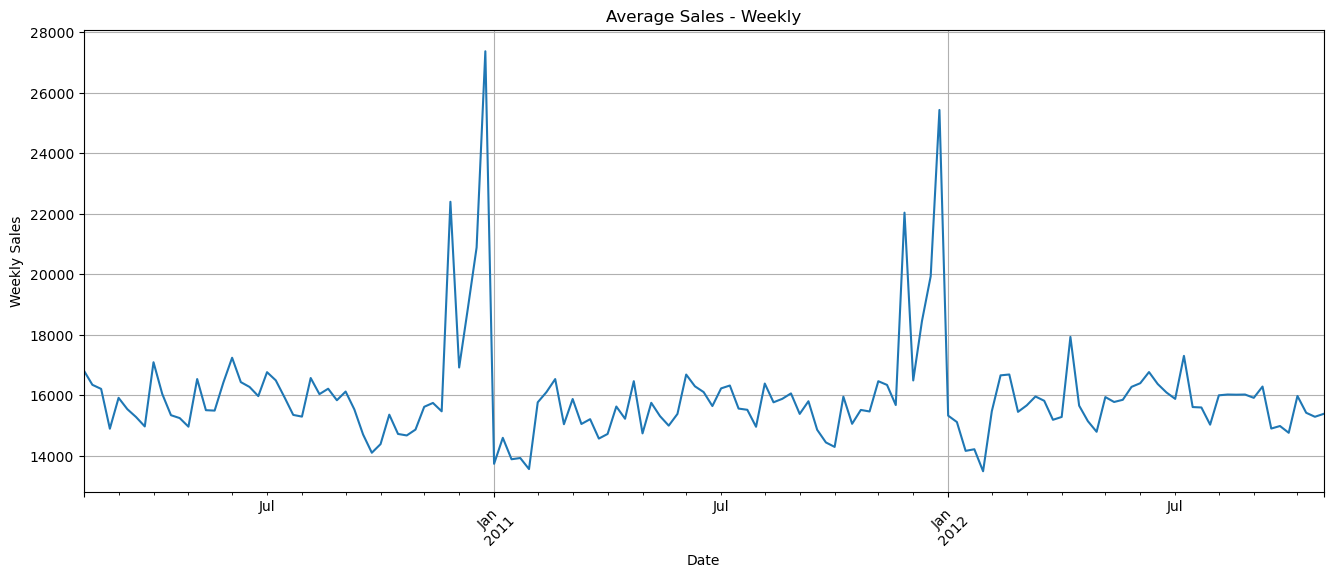

In [8]:
df_week = df_clean.resample('W').mean()  # Resample data as weekly

plt.figure(figsize=(16, 6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.xticks(rotation=45) 
plt.show()

In [9]:
def outlier_checker(df):

    """This function checks and prints the outliers in the dataset"""
    outlier_percentages = {}

    for column in df.select_dtypes(include=[np.number]):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_whisker = Q1 - 1.5 * IQR
        upper_whisker = Q3 + 1.5 * IQR
        
        num_outliers = ((df[column] < lower_whisker) | (df[column] > upper_whisker)).sum()
        
        percentage_outliers = (num_outliers / len(df)) * 100
        
        outlier_percentages[column] = percentage_outliers

    for column, percentage in outlier_percentages.items():
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")

In [10]:
outlier_checker(df_clean_encode)

Percentage of outliers in Store: 0.00%
Percentage of outliers in Dept: 0.00%
Percentage of outliers in Weekly_Sales: 8.43%
Percentage of outliers in IsHoliday: 7.04%
Percentage of outliers in Type: 0.00%
Percentage of outliers in Size: 0.00%
Percentage of outliers in Temperature: 0.00%
Percentage of outliers in Fuel_Price: 0.00%
Percentage of outliers in MarkDown1: 0.00%
Percentage of outliers in MarkDown2: 0.00%
Percentage of outliers in MarkDown3: 0.00%
Percentage of outliers in MarkDown4: 0.00%
Percentage of outliers in MarkDown5: 0.00%
Percentage of outliers in CPI: 0.00%
Percentage of outliers in Unemployment: 0.00%
Percentage of outliers in Week: 0.00%
Percentage of outliers in Month: 0.00%
Percentage of outliers in Year: 0.00%
Percentage of outliers in Super_Bowl: 2.11%
Percentage of outliers in Labour_Day: 2.10%
Percentage of outliers in Thanksgiving_Day: 1.41%
Percentage of outliers in Christmas: 1.41%


## Feature Selection

The selection of the features would be according to the best set of features selected by each algorithm that have the least MAE.

#### Feature Selection using RFE

In [240]:

def select_features_with_rfe(X, y):
    estimator = XGBRegressor()  # Choose an estimator suitable for your problem
    max_features = X.shape[1]
    best_score = float('inf')
    best_features = None
    
    for n_features in range(1, max_features + 1):
        rfe = RFE(estimator, n_features_to_select=n_features)
        rfe.fit(X, y)
        selected_features = rfe.support_
        
        # Evaluate model performance using cross-validation
        kf = KFold(n_splits=5)  # Adjust the number of folds as needed
        scores = []
        
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index].reset_index(drop=True), X.iloc[val_index].reset_index(drop=True)
            y_train, y_val = y.iloc[train_index].reset_index(drop=True), y.iloc[val_index].reset_index(drop=True)
            
            estimator.fit(X_train.loc[:, selected_features], y_train)
            y_pred = estimator.predict(X_val.loc[:, selected_features])
            score = mean_absolute_error(y_val, y_pred)
            scores.append(score)
        
        avg_score = np.mean(scores)
        
        if avg_score < best_score:
            best_score = avg_score
            best_features = X.columns[selected_features]
    
    return best_features


In [241]:
selected_features_rfe = select_features_with_rfe(X, y)
print("Selected Features:", selected_features_rfe.to_list())

Selected Features: ['Store', 'Dept', 'Type', 'Size', 'Week', 'Thanksgiving_Day']


In [242]:
reg = XGBRegressor().fit(X_train[selected_features_rfe], y_train)
print(f'MAE: {mean_absolute_error(y_test, reg.predict(X_test[selected_features_rfe]))}')
feature_importance['RFE'] = [mean_absolute_error(y_test, reg.predict(X_test[selected_features_rfe])), selected_features_rfe]

MAE: 2982.4174936813456


#### Feature Selection using Information Criterion

In [243]:
def select_features_with_info_criterion(X, y, info_criterion='aic'):
    estimator = XGBRegressor()  # Choose an estimator suitable for your problem
    selector = SelectFromModel(estimator, threshold=-np.inf, max_features=None)
    selector.fit(X, y)
    
    if info_criterion == 'aic':
        criterion_values = -2 * selector.estimator_.score(X, y) + 2 * (selector.n_features_in_ - 1)
    elif info_criterion == 'bic':
        n_samples = X.shape[0]
        criterion_values = -2 * selector.estimator_.score(X, y) + np.log(n_samples) * (selector.n_features_in_ - 1)
    else:
        raise ValueError("Invalid information criterion. Choose 'aic' or 'bic'.")
    
    selected_features = selector.get_support()
    
    return selected_features, criterion_values

In [244]:
info_criterion = 'bic'

selected_features_info, criterion_values = select_features_with_info_criterion(X, y, info_criterion)
print("Selected Features:", X.columns[selected_features_info])
print(f"{info_criterion.capitalize()} values:", criterion_values)

Selected Features: Index(['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Week', 'Month', 'Year',
       'Super_Bowl', 'Labour_Day', 'Thanksgiving_Day', 'Christmas'],
      dtype='object')
Bic values: 257.1296927604479


In [245]:
reg = XGBRegressor().fit(X_train[X.columns[selected_features_info]], y_train)
print(f'MAE: {mean_absolute_error(y_test, reg.predict(X_test[X.columns[selected_features_info]]))}')
feature_importance['info_criterion'] = [mean_absolute_error(y_test, reg.predict(X_test[selected_features_info])), selected_features_info]

MAE: 3493.404629625793


#### Feature Selection using Premutation Importance

In [246]:
def select_features_with_permutation_importance(X, y, mae_threshold=None, percentage=None):
    estimator = XGBRegressor()  # Choose an estimator suitable for your problem
    estimator.fit(X, y)
    result = permutation_importance(estimator, X, y, n_repeats=5, random_state=42)
    feature_importances = result.importances_mean
    
    if mae_threshold is not None:
        top_features_idx = np.where(feature_importances >= mae_threshold)[0]
    elif percentage is not None:
        num_features = int(X.shape[1] * percentage)
        top_features_idx = np.argsort(feature_importances)[::-1][:num_features]
    else:
        raise ValueError("Either mae_threshold or percentage should be provided.")
    
    selected_features = np.zeros(X.shape[1], dtype=bool)
    selected_features[top_features_idx] = True
    
    return selected_features

In [247]:
mae_threshold = 0.1
selected_features = select_features_with_permutation_importance(X, y, mae_threshold=mae_threshold)
print("Selected Features:", X.columns[selected_features])

percentage = 0.5
selected_features = select_features_with_permutation_importance(X, y, percentage=percentage)
print("Selected Features:", X.columns[selected_features])

percentage = 0.7
selected_features_perm = select_features_with_permutation_importance(X, y, percentage=percentage)
print("Selected Features:", X.columns[selected_features_perm])

Selected Features: Index(['Store', 'Dept', 'Size'], dtype='object')
Selected Features: Index(['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature', 'CPI',
       'Unemployment', 'Week', 'Thanksgiving_Day'],
      dtype='object')
Selected Features: Index(['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Week', 'Month', 'Year',
       'Labour_Day', 'Thanksgiving_Day'],
      dtype='object')


In [248]:
reg = XGBRegressor().fit(X_train[X.columns[selected_features_perm]], y_train)
print(f'MAE: {mean_absolute_error(y_test, reg.predict(X_test[X.columns[selected_features_perm]]))}')
feature_importance['permutation'] = [mean_absolute_error(y_test, reg.predict(X_test[selected_features_perm])), selected_features_perm]

MAE: 3351.073372179121


#### Feature Selection using Tree models importance

In [249]:
def select_features_with_tree_importance(X, y):
    rf = RandomForestRegressor()
    rf.fit(X, y)
    
    feature_importances = rf.feature_importances_
    sorted_features_idx = np.argsort(feature_importances)[::-1]
    
    selected_features = np.zeros(X.shape[1], dtype=bool)
    best_score = float('-inf')
    best_selected_features = None
    
    for n_features in range(1, len(sorted_features_idx) + 1):
        selected_features[sorted_features_idx[:n_features]] = True
        selected_columns = X.columns[selected_features]
        X_selected = X[selected_columns]
        
        model = XGBRegressor()  
        model.fit(X_selected, y)
        y_pred = model.predict(X_selected)
        score = -mean_absolute_error(y, y_pred)  # Negate the MAE to maximize
        
        if score > best_score:
            best_score = score
            best_selected_features = np.copy(selected_features)
    
    return best_selected_features

In [250]:
selected_features_tree = select_features_with_tree_importance(X, y)
print("Selected Features:", X.columns[selected_features_tree])

Selected Features: Index(['Store', 'Dept', 'Type', 'Size', 'Temperature', 'CPI', 'Unemployment',
       'Week', 'Thanksgiving_Day'],
      dtype='object')


In [251]:
reg = XGBRegressor().fit(X_train[X.columns[selected_features_tree]], y_train)
print(f'MAE: {mean_absolute_error(y_test, reg.predict(X_test[X.columns[selected_features_tree]]))}')
feature_importance['tree'] = [mean_absolute_error(y_test, reg.predict(X_test[selected_features_tree])), selected_features_tree]

MAE: 3385.9444554602437


#### Feature Selection using SelectKBest and Mutual Information Regression

In [258]:
def select_features_SelectKBest(X_train, y_train, X_test, y_test):
    feature_names = X_train.columns
    best_mae = float('inf')
    best_num_features = 0
    best_features = None

    for i in range(1, X_train.shape[1] + 1):
        # Select top K features using SelectKBest
        selector = SelectKBest(score_func=mutual_info_regression, k=i)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        selected_features_indices = selector.get_support(indices=True)
        selected_feature_names = feature_names[selected_features_indices]

        # Fit the model
        model = XGBRegressor()
        model.fit(X_train_selected, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test_selected)

        # Evaluate predictions
        mae = mean_absolute_error(y_test, y_pred)
        # print(f'MAE: {round(mae, 3)} for k value of: {i}')

        if mae < best_mae:
            best_mae = mae
            best_num_features = i
            best_features = selected_feature_names

    # print(f"Best MAE: {round(best_mae, 3)} for k value of: {best_num_features}")
    # print("Selected Features:", best_features)

    return best_features

In [259]:
selected_features_selectKbest = select_features_SelectKBest(X_train, y_train, X_test, y_test)

In [267]:
reg = XGBRegressor().fit(X_train[selected_features_selectKbest], y_train)
print(f'MAE: {mean_absolute_error(y_test, reg.predict(X_test[selected_features_selectKbest]))}')
feature_importance['SelectKBest'] = [mean_absolute_error(y_test, reg.predict(X_test[selected_features_selectKbest])), selected_features_selectKbest]

MAE: 3133.3987839842207


#### Selected Features

**The least MAE found by the use of RFE method with a MAE of 2982.**

`Selected Features`: ['Store', 'Dept', 'Type', 'Size', 'Week', 'Thanksgiving_Day']

## Model Selection

In [11]:
# Selecting the best features to train the models 

selected_features = ['Store', 'Dept', 'Type', 'Size', 'Week', 'Thanksgiving_Day']

X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((294132, 6), (127438, 6), (294132,), (127438,))

In [13]:
def resample_plot(arr1, arr2, only_resample=False, only_plot=True, resample_and_plot=False):

    """This function resamples the dataset in a Weekly format to be able to display it better"""

    if only_resample:
        plot = False
        return arr1.resmple('W').mean(), arr2.resample('W').mean()
    
    elif only_plot:
        arr1.resample('W').mean().plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
        arr2.resample('W').mean().plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
        plt.legend(['Train', 'Test'])
        plt.show()

    elif resample_and_plot:
        arr1.resample('W').mean().plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
        arr2.resample('W').mean().plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
        plt.legend(['Train', 'Test'])
        plt.show()
        return arr1.resmple('W').mean(), arr2.resample('W').mean()

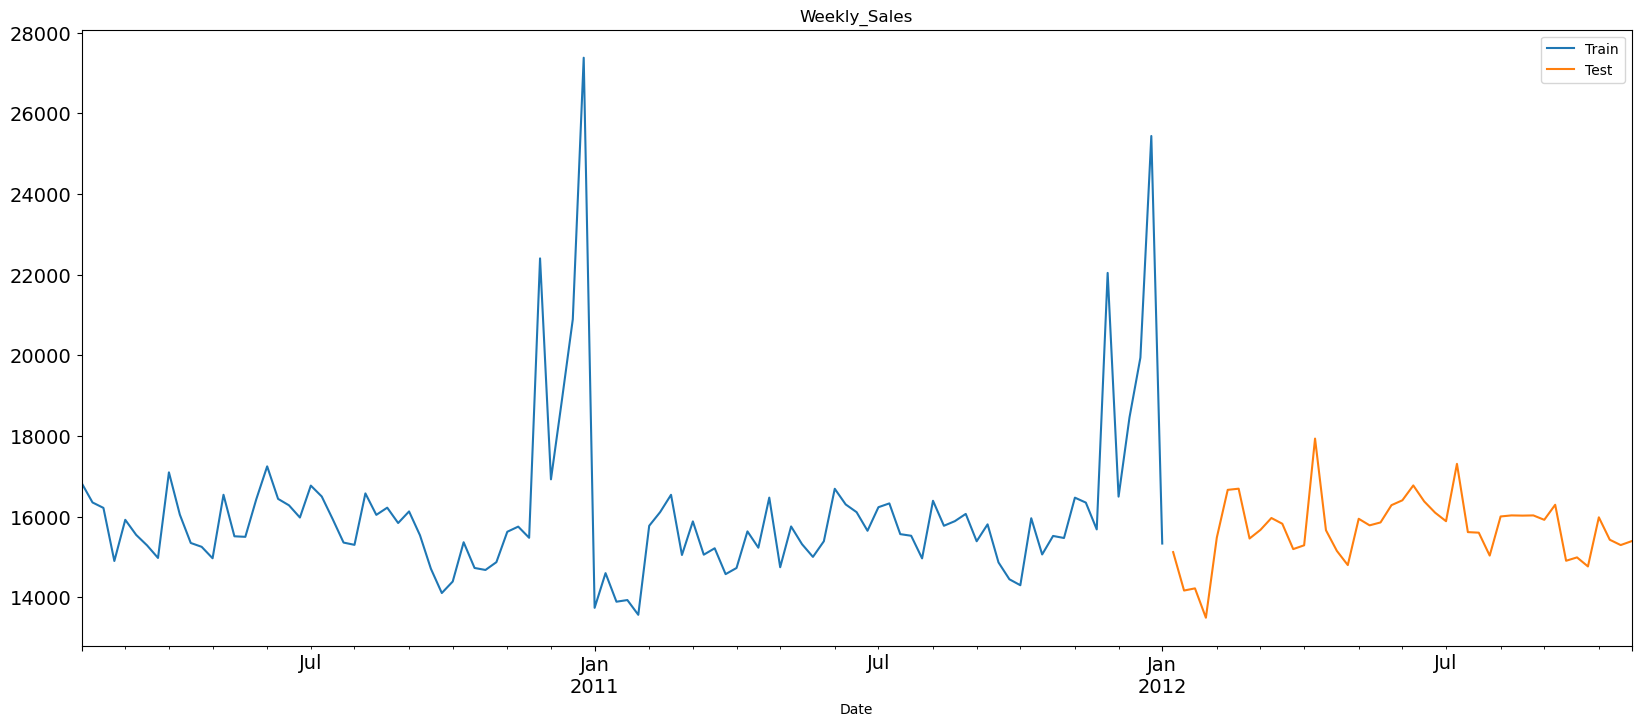

In [14]:
resample_plot(y_train, y_test)

In [481]:
def train_fit_predict_score(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test), model.predict(X_test)

In [17]:
models = {'RandomForestRegressor': RandomForestRegressor(),
          'XGBRegressor': XGBRegressor(),
          'LightGBM': lgb.LGBMRegressor(),
          'CatBoost': CatBoostRegressor(verbose=0),}

scores = {}

for name, model in models.items():
    r2, y_pred = train_fit_predict_score(X_train, X_test, y_train, y_test, model)
    mae = mean_absolute_error(y_test, y_pred)
    scores[name] = mae
    print(f'{name} training is done....')

RandomForestRegressor training is done....
XGBRegressor training is done....
LightGBM training is done....
CatBoost training is done....


In [18]:
scores

{'RandomForestRegressor': 1841.5834540025144,
 'XGBRegressor': 2982.4174936813456,
 'LightGBM': 4064.9648764615104,
 'CatBoost': 3276.06860685975}

#### Selected Models

**Models with best score were `RandomForestRegressor`, `XGBRegressor`, and `CatBoost`**.

## Hyperparamter tuning for Best Models

In [482]:
X = X[X_train.columns]
X.shape

(421570, 6)

In [483]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((294132, 6), (294132,), (127438, 6), (127438,))

#### Random Forest Regressor model paramters tuning

In [16]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 5],
}

In [18]:
reg_rf = RandomForestRegressor()
gridsearch = GridSearchCV(estimator=reg_rf, param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, 
                          return_train_score=True, verbose=1)

In [20]:
gridsearch.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [200, 300, 400, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [21]:
gridsearch.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [22]:
gridsearch.best_score_

-2265.455086559362

#### XGBoost Regression Model hyperparameter tuning

In [19]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [200, 300, 400]
}

In [20]:
reg_XGB = XGBRegressor()
gridsearch = GridSearchCV(estimator=reg_XGB, param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, 
                          return_train_score=True, verbose=1)

In [21]:
gridsearch.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'n_estimators': [200, 300, 400],
                         'subsample': [0.8, 1.0]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [22]:
gridsearch.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 400,
 'subsample': 1.0}

In [23]:
gridsearch.best_score_

-2953.3070835476847

#### Catboost Regression hyperparamter tuning

In [24]:
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'depth': [3, 5, 7],
    'subsample': [0.6, 0.8],
    'colsample_bylevel': [0.6, 0.8],
    'iterations': [200, 300, 400]
}

In [25]:
from catboost import CatBoostRegressor

In [26]:
reg_cbr = CatBoostRegressor()
gridsearch = GridSearchCV(estimator=reg_cbr, param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, 
                          return_train_score=True, verbose=1)

In [27]:
gridsearch.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0:	learn: 17286.4436378	total: 153ms	remaining: 1m 1s
1:	learn: 13777.8504399	total: 171ms	remaining: 34.1s
2:	learn: 12302.0388696	total: 189ms	remaining: 25.1s
3:	learn: 11745.1232942	total: 205ms	remaining: 20.3s
4:	learn: 11149.7664757	total: 221ms	remaining: 17.5s
5:	learn: 10756.6183104	total: 235ms	remaining: 15.4s
6:	learn: 10394.0925369	total: 252ms	remaining: 14.1s
7:	learn: 10130.1854830	total: 268ms	remaining: 13.1s
8:	learn: 9857.5321703	total: 284ms	remaining: 12.3s
9:	learn: 9711.2122854	total: 301ms	remaining: 11.7s
10:	learn: 9559.7547581	total: 317ms	remaining: 11.2s
11:	learn: 9438.0715414	total: 332ms	remaining: 10.7s
12:	learn: 9305.0168315	total: 349ms	remaining: 10.4s
13:	learn: 9231.4846241	total: 367ms	remaining: 10.1s
14:	learn: 8971.4867026	total: 384ms	remaining: 9.85s
15:	learn: 8864.5511691	total: 403ms	remaining: 9.67s
16:	learn: 8684.8145670	total: 422ms	remaining: 9.52s
17:	learn: 8478.60979

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001EE1E3290D0>,
             n_jobs=-1,
             param_grid={'colsample_bylevel': [0.6, 0.8], 'depth': [3, 5, 7],
                         'iterations': [200, 300, 400],
                         'learning_rate': [0.01, 0.1, 1],
                         'subsample': [0.6, 0.8]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [28]:
gridsearch.best_params_

{'colsample_bylevel': 0.8,
 'depth': 7,
 'iterations': 400,
 'learning_rate': 1,
 'subsample': 0.8}

In [29]:
gridsearch.best_score_

-2620.055155247922

## Model Evaluation

#### Loading test data 

**That contains all the features, but does not contain the target column**

In [15]:
model1 = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1,
                              max_depth=7, bootstrap=True, random_state=0).fit(X_train, y_train)

In [16]:
model2 = XGBRegressor(n_estimators=300, colsample_bytree=1.0, 
                      learning_rate=0.2, subsample=0.8, max_depth=5, random_state=0).fit(X_train, y_train)

In [17]:
model3 = CatBoostRegressor(iterations=400, colsample_bylevel=0.8, depth=7, 
                           subsample=0.8, learning_rate=1, verbose=0, random_state=0).fit(X_train, y_train)

In [18]:
from sklearn.linear_model import LinearRegression
# Create the stacking ensemble with one of the models as the meta-model
estimators = [('rf', model1), ('xgb', model2), ('catboost', model3)]
meta_model = model1  # Choose one of the models as the meta-model
stacking_model = StackingRegressor(estimators, final_estimator=LinearRegression())

# Fit the stacking ensemble to the training data
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=7,
                                                     n_estimators=200,
                                                     random_state=0)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=0, ...)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x0000025BA0DE0F40>)],
                  final_estimator=LinearRegression())

#### Models R^2 and MAE scores

In [19]:
def printing_scores_mae(r2_train, r2_test, mae, model_name):
    print(f'{model_name} Trianing set R^2 score : {r2_train}')
    print(f'{model_name} Testing set R^2 score : {r2_test}')
    print(f'{model_name} Testing set MAE score : {mae}')

In [20]:
printing_scores_mae(model1.score(X_train, y_train), model1.score(X_test, y_test), mean_absolute_error(y_test, model1.predict(X_test)), 'Random Forest')

Random Forest Trianing set R^2 score : 0.7624544989532017
Random Forest Testing set R^2 score : 0.7944343821047011
Random Forest Testing set MAE score : 6285.190734384476


In [21]:
printing_scores_mae(model2.score(X_train, y_train), model2.score(X_test, y_test), mean_absolute_error(y_test, model2.predict(X_test)), 'XGBoost')

XGBoost Trianing set R^2 score : 0.948074451685192
XGBoost Testing set R^2 score : 0.9455679333285798
XGBoost Testing set MAE score : 3063.3751180348117


In [22]:
printing_scores_mae(model3.score(X_train, y_train), model3.score(X_test, y_test), mean_absolute_error(y_test, model3.predict(X_test)), 'CatBoost')

CatBoost Trianing set R^2 score : 0.9696453537237703
CatBoost Testing set R^2 score : 0.9602074074282643
CatBoost Testing set MAE score : 2591.3319105548103


In [23]:
printing_scores_mae(stacking_model.score(X_train, y_train), stacking_model.score(X_test, y_test), mean_absolute_error(y_test, stacking_model.predict(X_test)), 'Stacking Regressor')

Stacking Regressor Trianing set R^2 score : 0.9694356436537296
Stacking Regressor Testing set R^2 score : 0.9604433105437998
Stacking Regressor Testing set MAE score : 2543.353521579216


In [24]:
def predict_plot(y_train, X_test, y_test, reg, test_data):
    y_pred = reg.predict(X_test)
    y_pred = pd.DataFrame(y_pred,index = X_test.index,columns=['Prediction'])

    y_pred_new = reg.predict(test_data)
    y_pred_new = pd.DataFrame(y_pred_new,index = test_data.index,columns=['Prediction'])

    plt.figure(figsize=(20,6))
    plt.title('Prediction of Weekly Sales', fontsize=20)
    plt.plot(y_train.resample('W').mean(), label='Training data')
    plt.plot(y_test.resample('W').mean(), label='Test data with target')
    plt.plot(y_pred_new.resample('W').mean(), label='Prediction of test data without target')
    plt.plot(y_pred.resample('W').mean(), label='Prediction of test data with target')
    plt.legend(loc='best')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Weekly Sales', fontsize=14)
    plt.show()

In [25]:
predict_plot(y_train, X_test, y_test, model1, test_data)

NameError: name 'test_data' is not defined

In [26]:
predict_plot(y_train, X_test, y_test, model2, test_data)

NameError: name 'test_data' is not defined

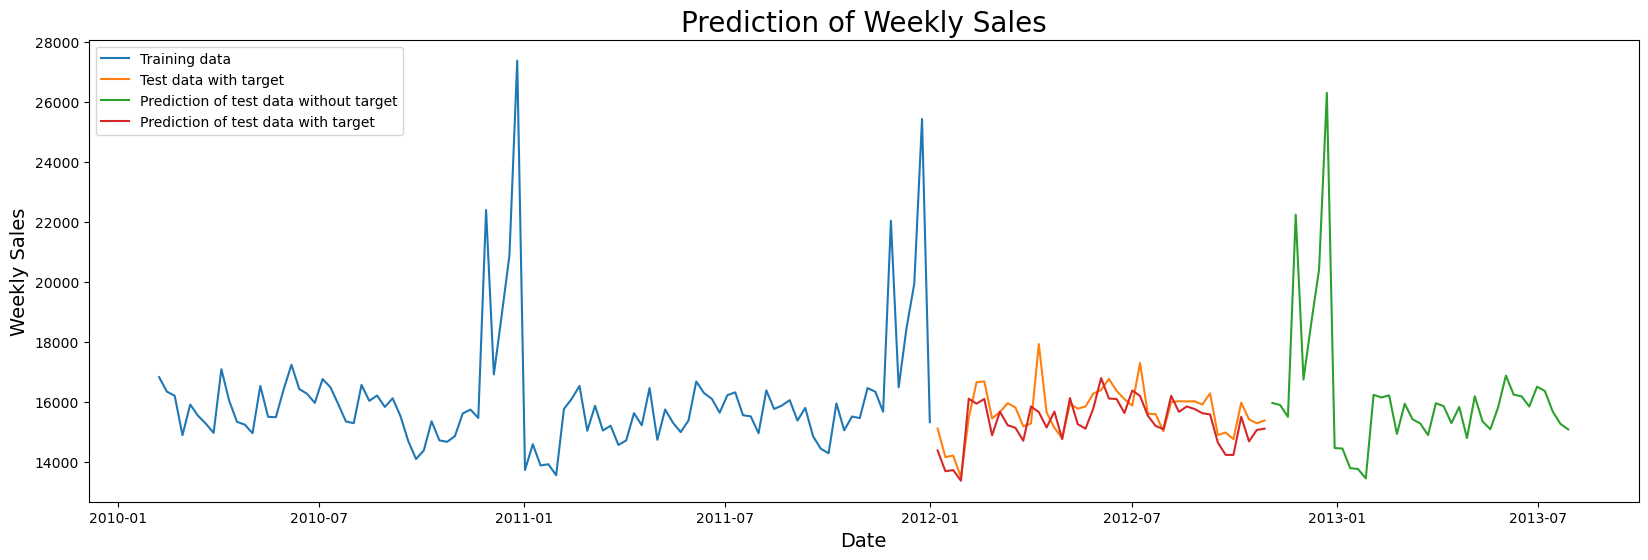

In [501]:
predict_plot(y_train, X_test, y_test, model3, test_data)

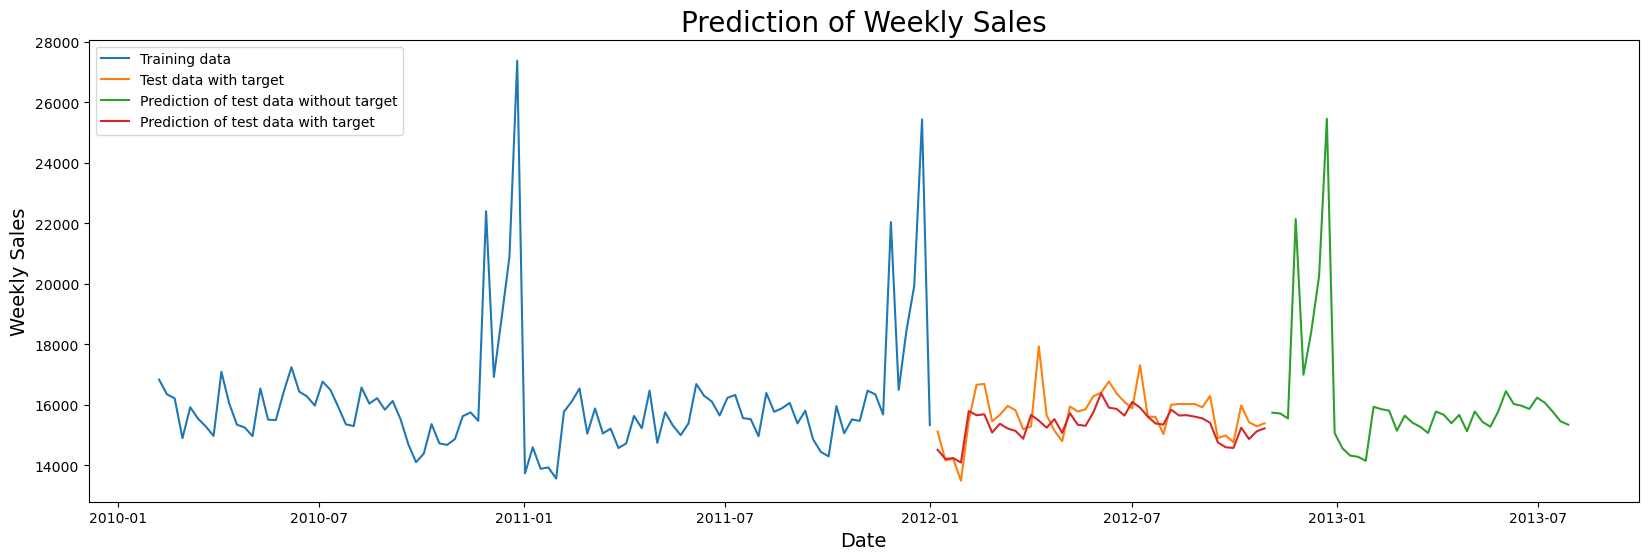

In [502]:
predict_plot(y_train, X_test, y_test, stacking_model, test_data)

#### Stacking Model Cross Validation Score using KFolds

In [82]:
kfold = KFold(n_splits=5)
scores = cross_val_score(stacking_model, X, y, cv=kfold, scoring ="neg_mean_absolute_error", n_jobs=-1)
print(scores.mean())

-2299.308853640527


## Model Exporting

In [29]:
import joblib

In [30]:
def model_export(model, file_name):
    with open(file_name, 'wb') as file:
        joblib.dump(model, file, compress=True)
        file.close()

def model_load(file_name):
    with open(file_name, 'rb') as file:
        return joblib.load(file)

In [31]:
## Saving models

model_export(model1, 'RandomForest_model.joblib')
model_export(model2, 'XGBRegressor_model.joblib')
model_export(model3, 'CatBoostRegressor_model.joblib')

model_export(stacking_model, 'Stacked_model.joblib')

In [512]:
## Loading models
# rf = model_load('RandomForest_model.joblib')
# xgb = model_load('XGBRegressor_model.joblib')
# cb = model_load('CatBoostRegressor_model.joblib')
# sm = model_load('Stacked_model.joblib')